# Segunda parte del Primer parcial

Implementar el Encoder en una gan, la parte generacional, y aplicar una valoracion en comparacion con una gann tradicional.
Realizar un informe completo.

Github https://github.com/bspoloo/SIS421-022025/tree/main/Parciales/Primer%20parcial/Parte%202

## 1.- Importacion de las librerias

En este parte del cuadernillo estamos importando todas las librerias necesarias para trabajar.

In [174]:
import torch
import torchvision
import numpy as np
from torch.utils.data.dataloader import DataLoader
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import math

device = "cuda" if torch.cuda.is_available() else "cpu" # Usamos GPU si lo tenemos disponible
print(f"Usando {device} device")


Usando cuda device


## 2.- Carga del Dataset FashionMNIST

En este apartado se esta cargando el dataset de FashionMNIST, el cual fue cargado localmente en este equipo, y tambien se hace la declaracion de clases totales, con un total de 10 clases

In [175]:
# Carga del dataset FashionMNIST
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

# Clases del dataset FashionMNIST
classes = ("t-shirt", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")

## 3.- Creacion de la clase Dataset

Esta clase herea de la clase Dataset, el cual en su constructor hace la normalizacion de todos los datos y los carga a una lista que ``imgs`` que es un atributo de la clase dataset, pasa lo mismo con los labels, lo que se hace es cargar los labels en tonsores con el dispositivo usado, en este caso se uso CUDA.

In [176]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        
        # Normalizamos y cargamos los datos en tensores
        self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
        
        # Cargamos los labels en tensores
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)
    
    def __len__(self):
        # retorna el tamaño del dataset
        return len(self.imgs)
    
        # retornamos el item en la posición index para cada img y su respectivo label
    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]

En este apartado hacemos la prueba del dataset, cargamos el trainset creado anteriormente, esto nos retorna una clase dataset, el cual si hacemos un leng nos sale que contiene en total 60000 elementos

In [177]:
train = Dataset(trainset=trainset)
len(train)

60000

En este apartado se hace la creacion de un Dataloader, el cual le pasamos el dataset de entrenamiento, mezclando los datos con shuffle= True

ahora para ver la forma de una imagen se usa ``iter()`` el cual nos permite iterar sobre un dataloarder y con ``next`` obtenemos el siguiente elemento, en este caso obtenemos el primer elemento, y mostramos la forma de cada uno, donde:

* img tiene la forma => [batches, ]

In [178]:
dataloader = DataLoader(train, batch_size=32, shuffle=True)
imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

## 4.- Grafica de imagenes del Dataset

En este apartado graficamos imagenes aleatoriamente tomadas del dataset, usando como filas 3, y como columnas 5.

Usando un indice aleatorio para tomarlo del dataset, obteniendo la imagen y su respectivo label

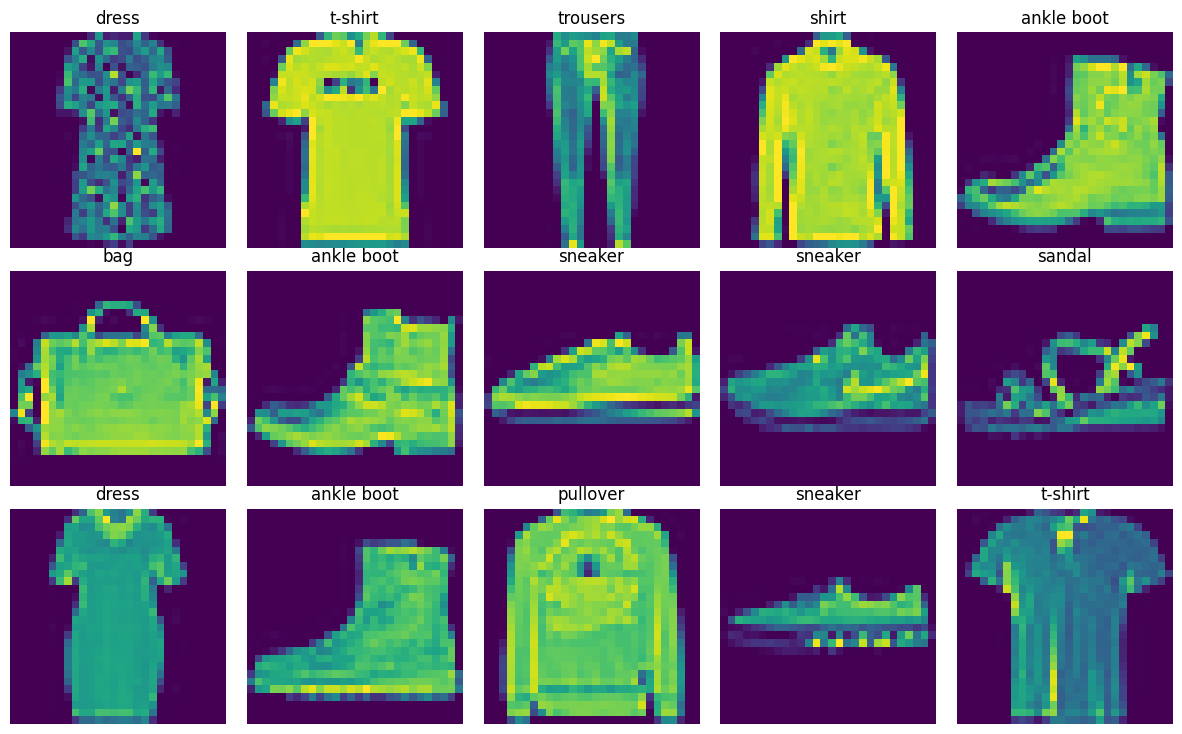

In [179]:
r, c, = 3,5

plt.figure(figsize=(c*3, r*3))

# Graficamos imagenes aleatorias del dataset
for row in range(r):
    for col in range(c):
        index = c*row + col;
        plt.subplot(r,c, index +1);
        ix = random.randint(0, len(train)-1); # indice aleatorio
        img, label = train[ix]; # obtenemos la imagen y su respectivo label
        plt.imshow(img.reshape(28,28).cpu());
        plt.axis('off')
        plt.title(classes[label.item()])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## 5.- Clase Multihead Attention

- En esta clase creamos un MultiheadAttention, el cual recibe parametros n_emb que seria el tamaño total de una imagen 28*28.
- Creamos cada capa lineal para K, Q y V, con entrada de ese total de **n_embd** y como salida **n_embd*n_heads**
- Creamos una capa de proyeccion lineal con entrada de n_emd*n_heads, n_embd

Aplicamos la formula de atencion correspontiene, 

In [ ]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # hacemos un reemsanblamiento, para que tenga la forma (B, L, F*n_heads)

        #retornamos la proyeccion lineal
        return self.proj(y)


## 6.- Bloque transformer encoder

Esta clase implementa un bloque básico del encoder de un Transformer. 

Su función es procesar una secuencia de vectores (por ejemplo, los patches de una imagen) y permitir que cada elemento de la secuencia aprenda de todos los demás, combinando atención y una red neuronal simple (MLP).

* Creamos nuestro bloque de atencion usando MultiheadAttention
* Creamos nuestras dos capas de normalizacion tomando como entrada el numero de embdding que en este caso seria el tamaño de la imange 28*28
* Creamos nuestra Feed forward como red neuronal secuencual, que contien capas lineales, GeLu y un Dropout para evitar el overfitting



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.attn = MultiHeadAttention(n_embd, n_heads) # Creamos nuestro bloque de Multihead Attention
        self.ln1 = nn.LayerNorm(n_embd) # Capa de normalizacion
        self.ln2 = nn.LayerNorm(n_embd) # Capa de normalizacion

        # Feedforward neural network
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # Capa lineal
            nn.GELU(), # Funcion de activacion
            nn.Linear(4 * n_embd, n_embd), # Capa lineal
            nn.Dropout(0.1)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Aqui aplicamos la atencion con la conexion residual, obivamente tomando en cuenta el dropout y la normalizacion
        attn_output = self.attn(x)
        x = self.ln1(x + self.dropout(attn_output))
        
        # Aqui aplicamos la red neuronal feedforward con la conexion residual, obivamente tomando en cuenta el dropout y la normalizacion
        ff_output = self.mlp(x)
        x = self.ln2(x + self.dropout(ff_output))
        
        return x

## 7.- Clase Generator

Esta clase lo que hace es transformar un vector de ruido aleatorio que tiene 100 dimensiones en una imagen realista de 28x28 píxeles que parezca del dataset Fashion MNIST.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_input=100, n_embd=128, seq_len=49, n_heads=8, n_layers=4):
        super().__init__()
        self.input_size = n_input
        self.seq_len = seq_len
        self.n_embd = n_embd
        
        # Aqui estamos definiendo la capa de entrada que proyecta el ruido a un espacio de embedding
        self.inp = nn.Sequential(
            nn.Linear(n_input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, seq_len * n_embd),
            nn.BatchNorm1d(seq_len * n_embd),
            nn.ReLU(True)
        )
        
        # Este es nuestro embedding posicional, que considera la posición de cada token en la secuencia
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, n_embd) * 0.02)
        
        # Aqui definimos los bloques transformer por cada n_layers que metemos como parametro en el constructor
        self.blocks = nn.Sequential(*[
            TransformerBlock(n_embd, n_heads) for _ in range(n_layers)
        ])
        
        # Esta es la normalizacion final despues del transformer
        self.ln_f = nn.LayerNorm(n_embd)
        
        # Este es nuestro CNN decoder para producir las imágenes de 28x28
        self.main = nn.Sequential(
            # 49 tokens -> 7x7 para tener un mapa de características con n_embd canales
            nn.ConvTranspose2d(n_embd, 128, 4, stride=2, padding=1, bias=False),  # 7x7 -> 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 14x14 -> 28x28
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 1, 3, padding=1, bias=False),
            nn.Tanh() # Usamos Tanh para que la salida esté en el rango [-1, 1]
        )

    def forward(self, z):
        batch_size = z.size(0)
        
        # Aplicamos una proyueccion lineal al ruido
        x = self.inp(z)
        x = x.view(batch_size, self.seq_len, self.n_embd)
        
        # Aplicamos la conexion posicional
        x = x + self.pos_embedding
        
        # Aqui aplicamos los bloques transformer y la normalizacion final
        x = self.blocks(x)
        x = self.ln_f(x)
        
        # Aqui es donde convertimos la salida del transformer en un mapa de características 7x7, ya que 7*7=49
        x = x.transpose(1, 2)
        x = x.view(batch_size, self.n_embd, 7, 7)
        
        # Finalmente aplicamos la CNN para obtener la imagen de 28x28 generada
        x = self.main(x)
        x = x.view(batch_size, -1)  # pero debemos aplanar a la imagen generada para tener la forma [batch, 28*28]
        
        return x

En este apartado instanciamos nuestro ``Generator`` lo cual es para nuestras imagenes de 28*28 tenemos que usar un seq_len de 7*7

Luego lo graficamos haciendo uso de la libreria **import matplotlib.pyplot as plt**

torch.Size([64, 784])


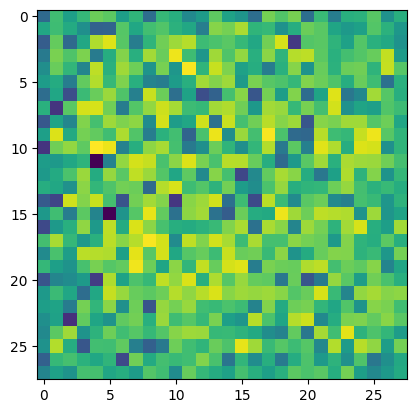

In [193]:
# Para imágenes 28x28, usa seq_len=7*7=49
generator = Generator(n_input=100, n_embd=128, seq_len=7*7, n_heads=4, n_layers=1)
output = generator(torch.randn(64, 100)) # Creamos un batch de 64 imagenes, con 100 dimensiones de ruido aleatorio
print(output.shape) 

# Aqui graficamos una de las imagenes generadas haciendo un resize a 28x28
plt.imshow(output[0].reshape(28,28).detach().numpy())
plt.show()

Como se pudo ver en nuestro Generator estamos usando ``self.tanh`` pero esto nos trae problemas ya que nos da valores entre -1 y 1, por lo cual se tuvo que  re-normalizar las imagenes que es encontraban en el dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device) # Normalizamos las imagenes a [0, 1] dividiendo entre 255
        self.imgs = self.imgs * 2. - 1. # Re-normalizamos a [-1, 1] para que coincida con la salida del generador
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device) # Cargamos los labels en tensores

    def __len__(self):
        # Aqui simplemente retornamos el tamaño del dataset
        return len(self.imgs)

    def __getitem__(self, ix):
        # retornamos el item en la posición index para cada img y su respectivo label
        return self.imgs[ix], self.labels[ix]

# Creamos el dataset con las imagenes re-normalizadas y mostramos su tamaño
train = Dataset(trainset)
len(train)

## 8.- Entreanmiento del modelo
Para esta funcion estamos pasando el Generador y el Discriminador, con un total de epocas de 30:

* Inicialemente argamos nuestros Generador y Discriminador al dispositivo CUDA
* Creamos un optimizer ADAM para Generador y Discrimienador con un learning__rate de 3e-4

In [ ]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4, betas=(0.5, 0.999))
    crit = nn.BCEWithLogitsLoss() if crit is None else crit
    
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    
    for epoch in mb:
        g.train()
        d.train()
        
        for X, y in progress_bar(dataloader, parent=mb):
            X = X.to(device)
            batch_size = X.size(0)
            
            # Aplanar las imágenes reales
            real_images = X.view(batch_size, -1)
            
            # Aqui entrenamos el Discriminador
            d_optimizer.zero_grad()
            
            # Imágenes reales
            real_labels = torch.ones(batch_size, 1).to(device)
            real_output = d(real_images)
            d_loss_real = crit(real_output, real_labels)
            
            # Imágenes falsas
            noise = torch.randn(batch_size, g.input_size).to(device)
            with torch.no_grad():
                fake_images = g(noise)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            fake_output = d(fake_images.detach())
            d_loss_fake = crit(fake_output, fake_labels)
            
            # Loss total del discriminador
            d_total_loss = d_loss_real + d_loss_fake
            d_total_loss.backward()
            d_optimizer.step()
            
            # Aqui entrenamos el Generador
            g_optimizer.zero_grad()
            
            noise = torch.randn(batch_size, g.input_size).to(device)
            fake_images = g(noise)
            fake_output = d(fake_images)
            
            # Queremos que el discriminador piense que las imágenes falsas son reales
            g_loss_val = crit(fake_output, real_labels)
            g_loss_val.backward()
            g_optimizer.step()
            
            # Aqui guardamos las pérdidas para monitorear
            d_loss.append(d_total_loss.item())
            g_loss.append(g_loss_val.item())
            
            # Logs
            mb.child.comment = f'g_loss {np.mean(g_loss[-10:]):.5f} d_loss {np.mean(d_loss[-10:]):.5f}'
        
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))
        
        # Limpiar listas para la siguiente época porque las estamos promediando
        g_loss, d_loss = [], []
    
    return hist


In [186]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [ ]:
dataloader = DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape # Batch de 32 imagenes de 28*28 aplanadas y sus respectivos labels

(torch.Size([32, 784]), torch.Size([32]))

In [ ]:
# este es nuestro Discriminador que clasifica imágenes reales vs falsas

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Aqui definimos la arquitectura del discriminador
        
        self.main = nn.Sequential(
            nn.Linear(784, 512), # Capa lineal que toma imágenes aplanadas de 28x28=784
            nn.LeakyReLU(0.2, inplace=True), # Función de activación LeakyReLU
            nn.Dropout(0.3),  # Dropout para evitar overfitting
            
            nn.Linear(512, 256), # Capa lineal
            nn.LeakyReLU(0.2, inplace=True), # Función de activación LeakyReLU
            nn.Dropout(0.3), # Dropout para evitar overfitting
            
            nn.Linear(256, 128), # Capa lineal
            nn.LeakyReLU(0.2, inplace=True), # Función de activación LeakyReLU
            nn.Dropout(0.3), # Dropout para evitar overfitting
            
            nn.Linear(128, 1) # Capa de salida que da un solo valor (logit) para clasificación binaria
        )
    
    def forward(self, x):
        return self.main(x)

En esta parte estamos entrenamos en modelo
Con los siguientes Hiperparametros:

lr = 1e -4
epcochs = 30
dropout = 0.3 para evitar overfiting


In [189]:
hist = fit(generator, Discriminator(), dataloader, epochs=30)

Epoch 1/30 | D Loss: 1.1853 | G Loss: 1.1364
Epoch 2/30 | D Loss: 1.2650 | G Loss: 0.8823
Epoch 3/30 | D Loss: 1.3148 | G Loss: 0.8068
Epoch 4/30 | D Loss: 1.3545 | G Loss: 0.7543
Epoch 5/30 | D Loss: 1.3648 | G Loss: 0.7397
Epoch 6/30 | D Loss: 1.3686 | G Loss: 0.7345
Epoch 7/30 | D Loss: 1.3731 | G Loss: 0.7164
Epoch 8/30 | D Loss: 1.3785 | G Loss: 0.7180
Epoch 9/30 | D Loss: 1.3788 | G Loss: 0.7134
Epoch 10/30 | D Loss: 1.3781 | G Loss: 0.7105
Epoch 11/30 | D Loss: 1.3812 | G Loss: 0.7061
Epoch 12/30 | D Loss: 1.3822 | G Loss: 0.7066
Epoch 13/30 | D Loss: 1.3817 | G Loss: 0.7072
Epoch 14/30 | D Loss: 1.3823 | G Loss: 0.6999
Epoch 15/30 | D Loss: 1.3824 | G Loss: 0.7032
Epoch 16/30 | D Loss: 1.3832 | G Loss: 0.7034
Epoch 17/30 | D Loss: 1.3836 | G Loss: 0.7068
Epoch 18/30 | D Loss: 1.3834 | G Loss: 0.7017
Epoch 19/30 | D Loss: 1.3817 | G Loss: 0.7059
Epoch 20/30 | D Loss: 1.3843 | G Loss: 0.6960
Epoch 21/30 | D Loss: 1.3845 | G Loss: 0.7017
Epoch 22/30 | D Loss: 1.3850 | G Loss: 0.69

## 9.- Analisis del model

como se puede observar la grafica anterior, el generador tiene una perdida muy curva al igual que el discriminador: 

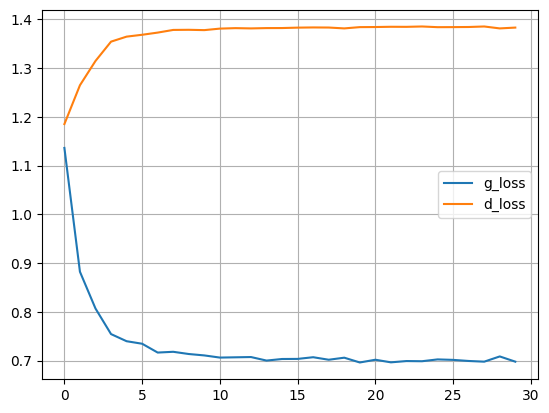

In [190]:
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

Como se puede ver que nuestra grafica anterior es mucho mejor que no usar usando Un encoder transformer, esto se representa en la siguiente grafica:

El cual fue utilizando un Gan normal

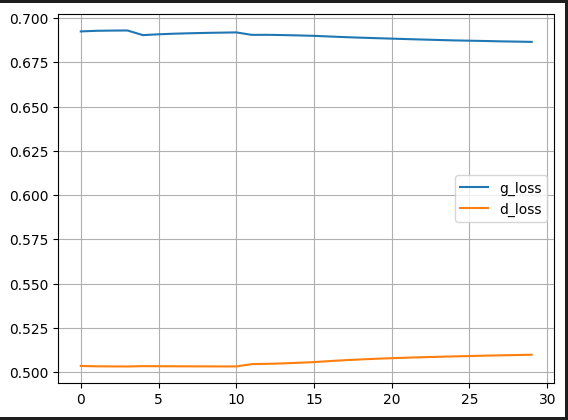

## 10.- Generacion de imagenes

En esta parte se procedio con la generacion de imagenes usando el modelo entrenado

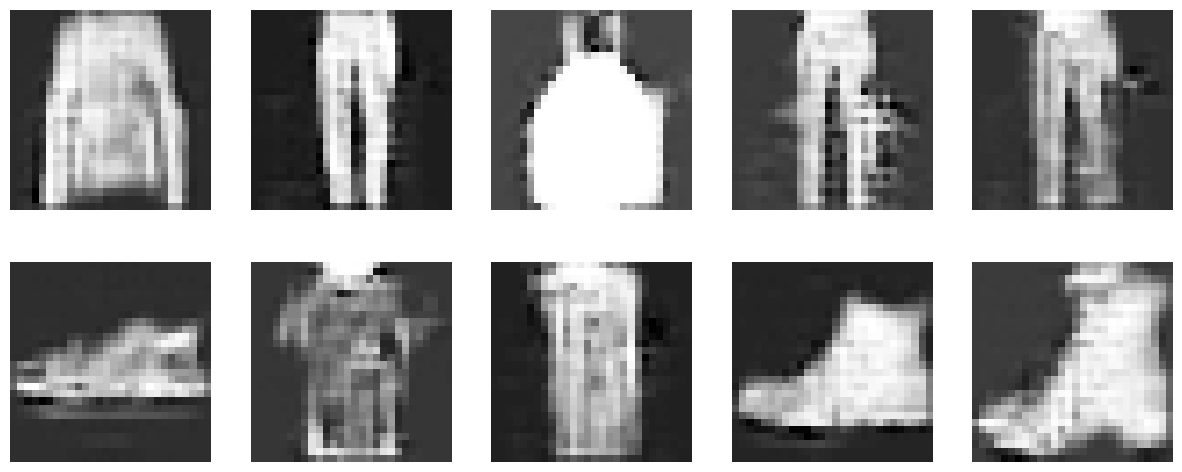

In [ ]:
# Ponemos el generador en modo evaluación y generamos algunas imágenes de ejemplo
generator.eval() 
# Ignoramos los cálculos de gradiente para generación de imágenes
with torch.no_grad():
    noise = torch.randn((10, generator.input_size)).to(device) # Generamos 10 vectores de ruido aleatorio
    generated_images = generator(noise)
    
    # Denormalizar de [-1, 1] a [0, 1]
    generated_images = (generated_images + 1) / 2 # Reescalamos a [0, 1]
    generated_images = generated_images.clamp(0, 1)  # Asegurar rango [0, 1]
    
    fig, axs = plt.subplots(2, 5, figsize=(15, 6)) # Creamos una figura con 2 filas y 5 columnas
    for i in range(10):
        ax = axs[i//5, i%5]
        img = generated_images[i].view(28, 28).cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()